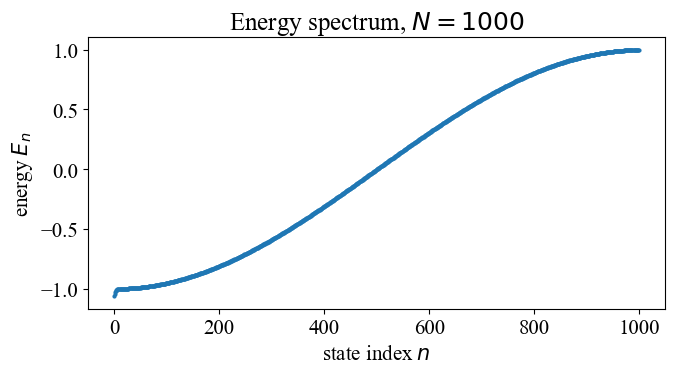

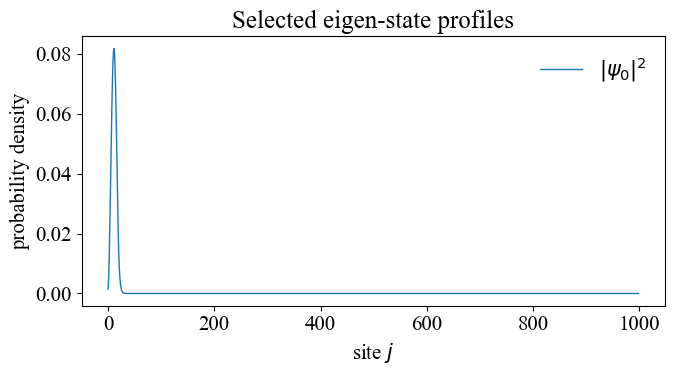

In [13]:
#!/usr/bin/env python3
# ---------------------------------------------------------------
#  Tight‑binding chain with 1/j‑type on‑site potential
#  H = (1/2ia) Σ_j (c†_j c_{j+1} − c†_{j+1} c_j) + Σ_j ε_j c†_j c_j
#  ε_j = -A / j                  for j ≥ j_c
#      = -A (3 j_c^2 − j)/2j_c^3 for j < j_c
# ---------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh            # dense Hermitian solver

# ----------------------------- parameters -----------------------------
N   = 1000        # system size
a   = 1.0         # lattice spacing (sets hopping scale)
jc  = 20          # crossover index j_c
A   = 1.0         # potential amplitude

# ------------------------ on‑site energy profile ----------------------
j   = np.arange(1, N + 1)                                 # 1 … N
eps = np.where(j >= jc,
               -A / j,
               -A * (3 * jc**2 - j) / (2 * jc**3))

# --------------------------- Hamiltonian ------------------------------
H   = np.zeros((N, N), dtype=complex)
t   = -1j / (2 * a)                                       # hopping

# nearest‑neighbour hopping (open boundaries)
idx = np.arange(N - 1)
H[idx,   idx + 1] = t
H[idx + 1, idx]   = t.conjugate()

# diagonal on‑site terms
H[np.diag_indices_from(H)] = eps

# ------------------------- diagonalisation ---------------------------
E, V = eigh(H)                                            # eigenvalues & vectors

# ---------------------------- plotting -------------------------------
plt.rcParams.update({"font.family": "Times New Roman", "font.size": 15})

# (1) energy spectrum
plt.figure(figsize=(7, 4))
plt.scatter(np.arange(N), E, s=4)
plt.xlabel(r"state index $n$")
plt.ylabel(r"energy $E_n$")
plt.title("Energy spectrum, $N=1000$")
plt.tight_layout()
plt.show()

# (2) a few eigen‑state densities
plt.figure(figsize=(7, 4))
states_to_show = [0]                          # lowest, mid‑band, highest
for k in states_to_show:
    plt.plot(np.arange(N), np.abs(V[:, k])**2, lw=1,
             label=rf"$| \psi_{k} |^2$")
plt.xlabel(r"site $j$")
plt.ylabel(r"probability density")
plt.title("Selected eigen‑state profiles")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [15]:
#DQPT paper extended model

import numpy as np

def idx_A(n):             # A sub-lattice index in the full 2N-dim basis
    return 2 * n

def idx_B(n):
    return 2 * n + 1

def build_extended_ssh(N, t_a=-1.0, t_b=-1.0, t_c=0.0, t_d=0.0,
                       periodic=False, dtype=np.complex128):
    """
    Construct the real-space Hamiltonian of the extended SSH chain.

    Parameters
    ----------
    N : int
        Number of unit cells (each cell has sites A and B, so dim = 2*N).
    t_a, t_b, t_c, t_d : float or complex
        Hopping amplitudes as defined above.
    periodic : bool, optional
        If True, uses periodic boundary conditions (PBC); otherwise open (OBC).
    dtype : numpy dtype
        Matrix numeric type.

    Returns
    -------
    H : (2N, 2N) ndarray
        The dense Hamiltonian matrix in the (A0,B0,…,A_{N-1},B_{N-1}) basis.
    """
    dim = 2 * N
    H = np.zeros((dim, dim), dtype=dtype)

    # loop over unit cells
    for n in range(N):
        # --- intracell hopping t_a ---
        H[idx_A(n), idx_B(n)] = t_a
        H[idx_B(n), idx_A(n)] = np.conj(t_a)

        # --- first-neighbour: t_b (A_n – B_{n-1}) ---
        if n > 0 or periodic:
            m = (n - 1) % N
            H[idx_A(n), idx_B(m)] = t_b
            H[idx_B(m), idx_A(n)] = np.conj(t_b)

        # --- first-neighbour: t_c (A_n – B_{n+1}) ---
        if n < N - 1 or periodic:
            m = (n + 1) % N
            H[idx_A(n), idx_B(m)] = t_c
            H[idx_B(m), idx_A(n)] = np.conj(t_c)

        # --- second-neighbour: t_d (A_n – B_{n-2}) ---
        if n > 1 or periodic:
            m = (n - 2) % N
            H[idx_A(n), idx_B(m)] = t_d
            H[idx_B(m), idx_A(n)] = np.conj(t_d)

    return H


In [18]:
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


# Parameters
L = 1000
sigma =1         # wrapping of space-time
w = 1
v_val = 0.5         # hopping amplitude

# Construct SSH Hamiltonian (L x L complex matrix)
SHH = np.zeros((L, L), dtype=complex)
for i in range(L - 1):
    v_i = v_val * ((i + 1) / (L - 1)) ** sigma
    w_i = w * ((i + 1) / (L - 1)) ** sigma
    if i % 2 == 0:
        SHH[i + 1, i] = -v_i
        SHH[i, i + 1] = -v_i
    else:
        SHH[i + 1, i] = -w_i
        SHH[i, i + 1] = -w_i

# Diagonalize the Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(build_extended_ssh)
#plt.scatter(np.arange(len(eigenvalues)), eigenvalues, s=2)


#-----------------------------------------------------------------------------------

# # Filter the eigenvalues and corresponding x-range (indices) to plot only for x = 450 to 550
x_min=450
x_max=550
x_range = np.arange(x_min, x_max)  # x indices from 450 to 550
filtered_eigenvalues = eigenvalues[x_min:x_max]

# # # Plot the filtered data
plt.scatter(x_range, filtered_eigenvalues, s=12, label=f'$\\sigma = {sigma}$')  

plt.xlabel('Index', fontsize= 30)
plt.ylabel('Eigenvalue',fontsize= 30)
plt.legend(fontsize= 26)
#plt.title(f'Topologically nontrivial SSH: v={v_val}, w={w}, ',fontsize= 18)
plt.show()

#--------------------------------------------------------------------------------------------------


# ------------------------------
# Plot probability density for zero energy states:
# Use eigenvectors corresponding to indices L//2 and L//2 - 1.
prob_density  = np.abs(eigenvectors[:, L // 2]) ** 2
prob_density2 = np.abs(eigenvectors[:, L // 2 - 1]) ** 2

plt.figure()
#plt.title("Probability density for zero energy states", fontsize=18)
# plt.plot(np.arange(len(eigenvalues)), prob_density, label=r'$|\psi_{N/2}|^2$')
# plt.plot(np.arange(len(eigenvalues)), prob_density2, label=r'$|\psi_{N/2-1}|^2$')

plt.plot(np.arange(len(eigenvalues)), prob_density2, 
         linestyle='-', marker='o', markersize=5, color='black', 
         label=r'$|\psi_{{N/2}}|^2$')
plt.plot(np.arange(len(eigenvalues)), prob_density, 
         linestyle='-.', marker='s', markersize=5, color='blue', 
         label=r'$|\psi_{{N/2-1}}|^2 $')
plt.xlabel('Index', fontsize= 30)
plt.ylabel(r'$|\psi_{0}|^2 $',fontsize= 30)
#plt.xlim(0,10)
plt.legend(loc='upper center',fontsize=26)


# ------------------------------


#------------------------------------------------------------------------------------------------------------




# Number of eigenvectors
num_eigenvectors = len(eigenvalues)

# Number of eigenvectors to include in each matrix (half in each case)
num_eigenvectors_half = num_eigenvectors // 2

# matrix from the first half of the eigenvectors
Um= np.column_stack(eigenvectors[:, :num_eigenvectors_half])

# matrix from the remaining half of the eigenvectors
Up= np.column_stack(eigenvectors[:, num_eigenvectors_half:])

trans_Um = np.transpose(Um)
trans_Up= np.transpose(Up)

Pp= trans_Up@Up
Pm=trans_Um@Um
Q=Pp-Pm
GA=np.zeros((L,L))
GB=np.zeros((L,L))
for i in range(len(eigenvalues)):
    if i % 2 == 0:
      GA[i,i]=1
for i in range(len(eigenvalues)):
    if i % 2 != 0:
      GB[i,i]=1

Qab= GA@Q@GB
Qba= GB@Q@GA
l=np.arange(-abs(L/4), abs(L/4) , 1 )
X= np.zeros((L,L))
X[0,0]=-L/4
for i in range(len(eigenvalues)):
        if i % 2 == 0:
         X[i,i]=-L/4+i/2
         X[i+1,i+1]=X[i,i]
#print(np.shape(GA))
#print(X)

v1=1/2*(Qba@(X@Qab-Qab@X))
v2=1/2*(Qab@(Qba@X-X@Qba))
#print(v1)
#--------------------------------------------
v=np.zeros(int(L/2))
#--------------------------------------- 
for i in range(int(L/2)-1):
    v[i]  = v1[2*i,2*i]+v1[2*i+1,2*i+1]+v2[2*i,2*i]+v2[2*i+1,2*i+1]
#print(v)
plt.figure()
plt.title("Topological marker")
plt.xlabel("(l)--->")
plt.ylabel("v(l)--->")
plt.scatter(np.arange(len(v)),v,s=3)

# Limit the y-axis from -3 to 3
plt.ylim(-3, 3)

# Determine the middle value (v at L/2)
v_middle = v[len(v)//2]  # This is equivalent to v[250] when L = 1000

# Annotate the graph with the v(L/2) value.
# Adjust the x and y coordinates in plt.text as needed.
plt.text(0.6 * len(v), v_middle, f"v(L/2) = {v_middle:.3f}", 
         fontsize=12, color='blue', 
         bbox=dict(facecolor='white', alpha=0.1))

plt.show()
print(X[0,0])
print(max(prob_density))
print(max(prob_density2))
print(f"topological marker in bulk(sigma={sigma}))",v[250])


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

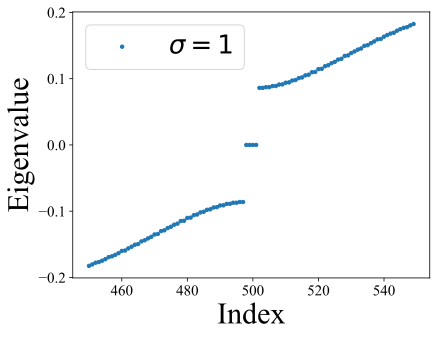

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19796\2646730841.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  v[i] = (v1[2*i,2*i] + v1[2*i+1,2*i+1] +


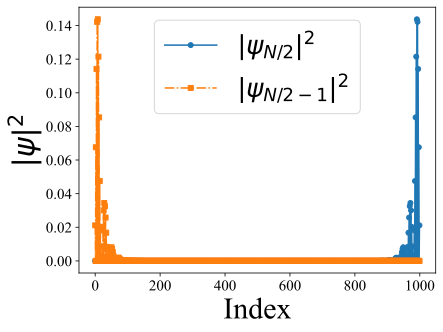

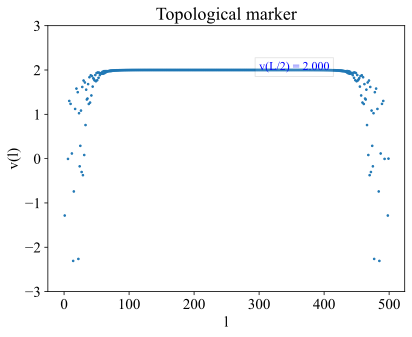

topological marker in bulk (σ=1): 1.9999999976822376


In [41]:
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# --- ADD THIS FUNCTION AFTER YOUR IMPORTS ---
def idx_A(n):
    return 2 * n

def idx_B(n):
    return 2 * n + 1

def build_extended_ssh(N, t_a, t_b, t_c, t_d,
                       periodic=False, dtype=np.complex128):
    dim = 2 * N
    H = np.zeros((dim, dim), dtype=dtype)
    for n in range(N):
        # intracell
        H[idx_A(n), idx_B(n)] = t_a
        H[idx_B(n), idx_A(n)] = np.conj(t_a)
        # A_n – B_{n-1}
        if n > 0 or periodic:
            m = (n - 1) % N
            H[idx_A(n), idx_B(m)] = t_b
            H[idx_B(m), idx_A(n)] = np.conj(t_b)
        # A_n – B_{n+1}
        if n < N - 1 or periodic:
            m = (n + 1) % N
            H[idx_A(n), idx_B(m)] = t_c
            H[idx_B(m), idx_A(n)] = np.conj(t_c)
        # A_n – B_{n-2}
        if n > 1 or periodic:
            m = (n - 2) % N
            H[idx_A(n), idx_B(m)] = t_d
            H[idx_B(m), idx_A(n)] = np.conj(t_d)
    return H
# --- END ADDITION ---

# Parameters
L = 1000
sigma = 1         # wrapping of space-time (unused by extended model)
w = 1
v_val = 0.5       # hopping amplitude (maps to t_b/t_c below)

# ----------------------------------------------------------------
# REPLACE THIS ENTIRE BLOCK:
# SHH = np.zeros((L, L), dtype=complex)
# for i in range(L - 1):
#     v_i = v_val * ((i + 1) / (L - 1)) ** sigma
#     w_i = w * ((i + 1) / (L - 1)) ** sigma
#     if i % 2 == 0:
#         SHH[i + 1, i] = -v_i
#         SHH[i, i + 1] = -v_i
#     else:
#         SHH[i + 1, i] = -w_i
#         SHH[i, i + 1] = -w_i
#
# # Diagonalize the Hamiltonian
# eigenvalues, eigenvectors = np.linalg.eigh(SHH)
# ----------------------------------------------------------------

# USE THE EXTENDED SSH INSTEAD:
# Here we take N = L//2 unit cells, 
# and set t_a=0 (no on-site), t_b = -v_val, t_c = -w, t_d = 0 (or any t_d you like).
N = L//2
SHH = build_extended_ssh(
    N,
    t_a=-1,
    t_b=-1,
    t_c=1,
    t_d=1.2,
    periodic=False
)
eigenvalues, eigenvectors = np.linalg.eigh(SHH)

# (the rest of your plotting / topological-marker code follows unchanged)
#-----------------------------------------------------------------------------------

# Filter the eigenvalues and corresponding x-range (indices) to plot only for x = 450 to 550
x_min = 450
x_max = 550
x_range = np.arange(x_min, x_max)
filtered_eigenvalues = eigenvalues[x_min:x_max]

plt.scatter(x_range, filtered_eigenvalues, s=12, label=f'$\\sigma = {sigma}$')  
plt.xlabel('Index', fontsize=30)
plt.ylabel('Eigenvalue', fontsize=30)
plt.legend(fontsize=26)
plt.show()

# Probability densities for the two zero‐energy states
prob_density  = np.abs(eigenvectors[:, L // 2]) ** 2
prob_density2 = np.abs(eigenvectors[:, L // 2 - 1]) ** 2

plt.figure()
plt.plot(np.arange(len(eigenvalues)), prob_density2, 
         linestyle='-', marker='o', markersize=5, label=r'$|\psi_{N/2}|^2$')
plt.plot(np.arange(len(eigenvalues)), prob_density, 
         linestyle='-.', marker='s', markersize=5, label=r'$|\psi_{N/2-1}|^2$')
plt.xlabel('Index', fontsize=30)
plt.ylabel(r'$|\psi|^2$', fontsize=30)
plt.legend(loc='upper center', fontsize=26)

# Compute topological marker exactly as before
num_eigenvectors = len(eigenvalues)
num_eigenvectors_half = num_eigenvectors // 2
Um = np.column_stack(eigenvectors[:, :num_eigenvectors_half])
Up = np.column_stack(eigenvectors[:, num_eigenvectors_half:])
Pp = Up.T @ Up
Pm = Um.T @ Um
Q = Pp - Pm

GA = np.zeros((L, L))
GB = np.zeros((L, L))
for i in range(L):
    GA[i, i] = (i % 2 == 0)
    GB[i, i] = (i % 2 == 1)

Qab = GA @ Q @ GB
Qba = GB @ Q @ GA

X = np.zeros((L, L))
for i in range(L):
    X[i, i] = -L/4 + (i//2)

v1 = 0.5 * (Qba @ (X @ Qab - Qab @ X))
v2 = 0.5 * (Qab @ (Qba @ X - X @ Qba))

v = np.zeros(L//2)
for i in range(L//2 - 1):
    v[i] = (v1[2*i,2*i] + v1[2*i+1,2*i+1] +
            v2[2*i,2*i] + v2[2*i+1,2*i+1])

plt.figure()
plt.title("Topological marker")
plt.xlabel("l")
plt.ylabel("v(l)")
plt.scatter(np.arange(len(v)), v, s=3)
plt.ylim(-3, 3)

v_middle = v[len(v)//2]
plt.text(0.6 * len(v), v_middle, f"v(L/2) = {v_middle:.3f}",
         fontsize=12, color='blue',
         bbox=dict(facecolor='white', alpha=0.1))

plt.show()

print(f"topological marker in bulk (σ={sigma}):", v_middle)


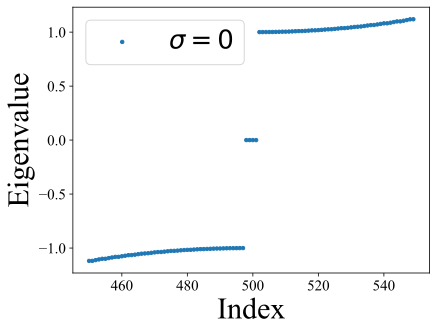

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19796\1209249003.py:142: ComplexWarning: Casting complex values to real discards the imaginary part
  v[i] = (v1[2*i,2*i] + v1[2*i+1,2*i+1] +


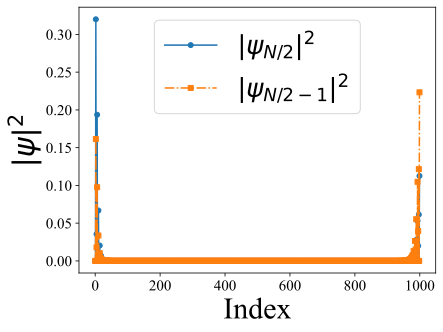

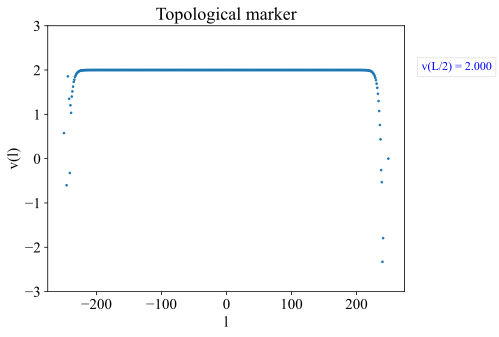

topological marker in bulk (σ=0): 1.9999999999999996


In [137]:
#CST extended SSH

%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# --- ADD THIS FUNCTION AFTER YOUR IMPORTS ---
def idx_A(n):
    return 2 * n

def idx_B(n):
    return 2 * n + 1

def build_extended_ssh(N, t_a, t_b, t_c, t_d, sigma,
                       periodic=False, dtype=np.complex128):
    dim = 2 * N
    H = np.zeros((dim, dim), dtype=dtype)
    for n in range(N):
        # intracell
        ta_i = t_a * ((n + 1) / (dim - 1)) ** sigma
        H[idx_A(n), idx_B(n)] = ta_i
        H[idx_B(n), idx_A(n)] = np.conj(ta_i)
        # A_n – B_{n-1}
        if n > 0 or periodic:
            m = (n - 1) % N
            tb_i = t_b * ((n + 1) / (dim - 1)) ** sigma
            H[idx_A(n), idx_B(m)] = tb_i
            H[idx_B(m), idx_A(n)] = np.conj(tb_i)
        # A_n – B_{n+1}
        if n < N - 1 or periodic:
            m = (n + 1) % N
            tc_i = t_c * ((n + 1) / (dim - 1)) ** sigma
            H[idx_A(n), idx_B(m)] = tc_i
            H[idx_B(m), idx_A(n)] = np.conj(tc_i)
        # A_n – B_{n-2}
        if n > 1 or periodic:
            m = (n - 2) % N
            td_i = t_d * ((n + 1) / (dim - 1)) ** sigma
            H[idx_A(n), idx_B(m)] = td_i
            H[idx_B(m), idx_A(n)] = np.conj(td_i)
    return H
# --- END ADDITION ---

# Parameters
L = 1000
sigma = 0         # wrapping of space-time (unused by extended model)
w = 1
v_val = 0.5       # hopping amplitude (maps to t_b/t_c below)

# ----------------------------------------------------------------
# REPLACE THIS ENTIRE BLOCK:
# SHH = np.zeros((L, L), dtype=complex)
# for i in range(L - 1):
#     v_i = v_val * ((i + 1) / (L - 1)) ** sigma
#     w_i = w * ((i + 1) / (L - 1)) ** sigma
#     if i % 2 == 0:
#         SHH[i + 1, i] = -v_i
#         SHH[i, i + 1] = -v_i
#     else:
#         SHH[i + 1, i] = -w_i
#         SHH[i, i + 1] = -w_i
#
# # Diagonalize the Hamiltonian
# eigenvalues, eigenvectors = np.linalg.eigh(SHH)
# ----------------------------------------------------------------

# USE THE EXTENDED SSH INSTEAD:
# Here we take N = L//2 unit cells, 
# and set t_a=0 (no on-site), t_b = -v_val, t_c = -w, t_d = 0 (or any t_d you like).
N = L//2
SHH = build_extended_ssh(
    N,
    t_a=2,
    t_b=1,
    t_c=-1,
    t_d=-3,
    sigma=0,
    
    periodic=False
)
eigenvalues, eigenvectors = np.linalg.eigh(SHH)

# (the rest of your plotting / topological-marker code follows unchanged)
#-----------------------------------------------------------------------------------

# Filter the eigenvalues and corresponding x-range (indices) to plot only for x = 450 to 550
x_min = 450
x_max = 550
x_range = np.arange(x_min, x_max)
filtered_eigenvalues = eigenvalues[x_min:x_max]

plt.scatter(x_range, filtered_eigenvalues, s=12, label=f'$\\sigma = {sigma}$')  
plt.xlabel('Index', fontsize=30)
plt.ylabel('Eigenvalue', fontsize=30)
plt.legend(fontsize=26)
plt.show()

# Probability densities for the two zero‐energy states
prob_density  = np.abs(eigenvectors[:, L // 2]) ** 2
prob_density2 = np.abs(eigenvectors[:, L // 2 - 1]) ** 2

plt.figure()
plt.plot(np.arange(len(eigenvalues)), prob_density2, 
         linestyle='-', marker='o', markersize=5, label=r'$|\psi_{N/2}|^2$')
plt.plot(np.arange(len(eigenvalues)), prob_density, 
         linestyle='-.', marker='s', markersize=5, label=r'$|\psi_{N/2-1}|^2$')
plt.xlabel('Index', fontsize=30)
plt.ylabel(r'$|\psi|^2$', fontsize=30)
plt.legend(loc='upper center', fontsize=26)

# Compute topological marker exactly as before
num_eigenvectors = len(eigenvalues)
num_eigenvectors_half = num_eigenvectors // 2
Um = np.column_stack(eigenvectors[:, :num_eigenvectors_half])
Up = np.column_stack(eigenvectors[:, num_eigenvectors_half:])
Pp = Up.T @ Up
Pm = Um.T @ Um
Q = Pp - Pm

GA = np.zeros((L, L))
GB = np.zeros((L, L))
for i in range(L):
    GA[i, i] = (i % 2 == 0)
    GB[i, i] = (i % 2 == 1)

Qab = GA @ Q @ GB
Qba = GB @ Q @ GA

X = np.zeros((L, L))
for i in range(L):
    X[i, i] = -L/4 + (i//2)

v1 = 0.5 * (Qba @ (X @ Qab - Qab @ X))
v2 = 0.5 * (Qab @ (Qba @ X - X @ Qba))

v = np.zeros(L//2)
for i in range(L//2 - 1):
    v[i] = (v1[2*i,2*i] + v1[2*i+1,2*i+1] +
            v2[2*i,2*i] + v2[2*i+1,2*i+1])

plt.figure()
plt.title("Topological marker")
plt.xlabel("l")
plt.ylabel("v(l)")
plt.scatter(l, v, s=3)
plt.ylim(-3, 3)

v_middle = v[len(v)//2]
plt.text(0.6 * len(v), v_middle, f"v(L/2) = {v_middle:.3f}",
         fontsize=12, color='blue',
         bbox=dict(facecolor='white', alpha=0.1))

plt.show()

print(f"topological marker in bulk (σ={sigma}):", v_middle)


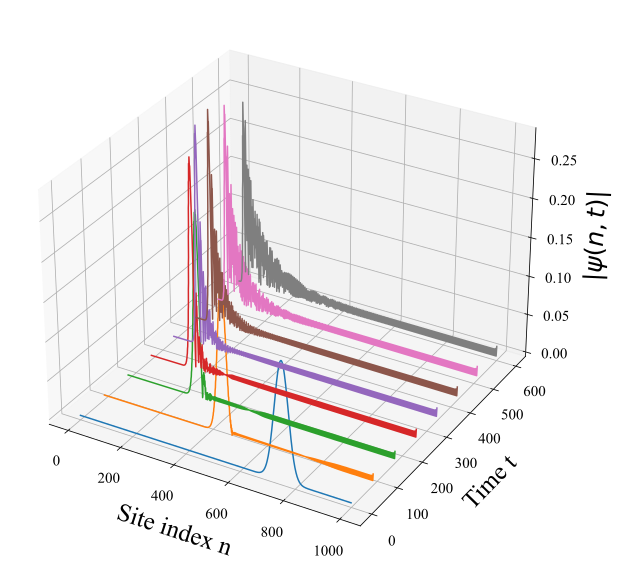

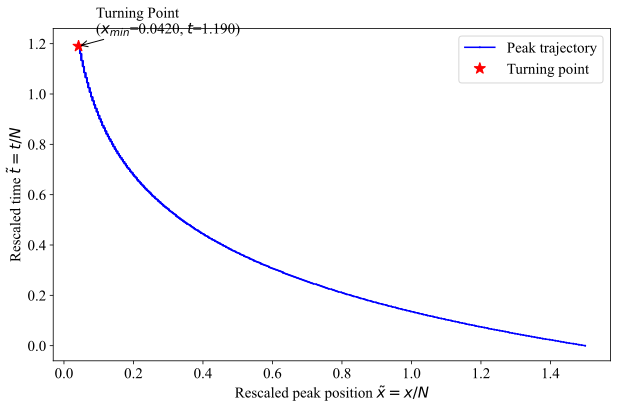

In [ ]:
#SSH Time evolution


import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting toolkit



######################################################################################

def idx_A(n):
    return 2 * n

def idx_B(n):
    return 2 * n + 1

def build_extended_ssh(N, t_a, t_b, t_c, t_d, sigma,
                       periodic=False, dtype=np.complex128):
    dim = 2 * N
    H = np.zeros((dim, dim), dtype=dtype)
    for n in range(N):
        # intracell
        ta_i = t_a * ((n + 1) / (dim - 1)) ** sigma
        H[idx_A(n), idx_B(n)] = ta_i
        H[idx_B(n), idx_A(n)] = np.conj(ta_i)
        # A_n – B_{n-1}
        if n > 0 or periodic:
            m = (n - 1) % N
            tb_i = t_b * ((n + 1) / (dim - 1)) ** sigma
            H[idx_A(n), idx_B(m)] = tb_i
            H[idx_B(m), idx_A(n)] = np.conj(tb_i)
        # A_n – B_{n+1}
        if n < N - 1 or periodic:
            m = (n + 1) % N
            tc_i = t_c * ((n + 1) / (dim - 1)) ** sigma
            H[idx_A(n), idx_B(m)] = tc_i
            H[idx_B(m), idx_A(n)] = np.conj(tc_i)
        # A_n – B_{n-2}
        if n > 1 or periodic:
            m = (n - 2) % N
            td_i = t_d * ((n + 1) / (dim - 1)) ** sigma
            H[idx_A(n), idx_B(m)] = td_i
            H[idx_B(m), idx_A(n)] = np.conj(td_i)
    return H


######################################################################################
def build_ssh_hamiltonian(N, v, w, sigma):
    """
    Build the SSH Hamiltonian on a 1D lattice of N sites.
    """
    H = np.zeros((N, N), dtype=complex)
    for i in range(N-1):
        # Scale the hopping amplitudes with position
        v_i = v * ((i + 1) / (N-1))**sigma
        w_i = w * ((i + 1) / (N-1))**sigma
        if i % 2 == 0:
            H[i, i+1] = -v_i
            H[i+1, i] = -v_i
        else:
            H[i, i+1] = -w_i
            H[i+1, i] = -w_i
    return H

###########################################
# New SSH Hamiltonian with additional hoppings and updated parameters
def SSH(L,c,sigma):
    """
    Construct the SSH Hamiltonian with additional hoppings for a given 
    winding number parameter c and exponent sigma, using updated parameters.
    """
    if c == 2:
        t = 0.1
        dt = -0.1
        w_val = t - dt    # Note: w = t - dt
        v_val = t + dt    # v = t + dt
        nu = 0.5
        mu = 0.2
        gamma = 0.4
    elif c == 4:
        t = 0.20
        dt = 0.05
        w_val = t - dt
        v_val = t + dt
        nu = 0.50
        mu = 0.20
        gamma = 0.40
    elif c == 3:
        t = 0.3
        dt = -0.2
        w_val = t - dt
        v_val = t + dt
        nu = 0.35
        mu = 0.6
        gamma = 0
    elif c == 1:
        t = 0.75
        dt = -0.25
        w_val = t - dt
        v_val = t + dt
        nu = 0
        mu = 0
        gamma = 0
    elif c == 0:
        t = 0.75
        dt = 0.25
        w_val = t - dt
        v_val = t + dt
        nu = 0
        mu = 0
        gamma = 0

    # Build the Hamiltonian matrix SHH (LxL complex matrix)
    SHH = np.zeros((L, L), dtype=complex)
    
    # Nearest-neighbor hopping
    for i in range(L - 1):
        v_i = v_val * ((i + 1) / (L - 1))**sigma
        w_i = w_val * ((i + 1) / (L - 1))**sigma
        if i % 2 == 0:
            SHH[i + 1, i] = -v_i
            SHH[i, i + 1] = -v_i
        else:
            SHH[i + 1, i] = -w_i
            SHH[i, i + 1] = -w_i

    # Next-nearest and further neighbor hoppings:
    for i in range(L - 3):
        nu_i = nu * ((i + 1) / (L - 1))**sigma
        if i % 2 != 0:
            SHH[i + 3, i] = nu_i
            SHH[i, i + 3] = nu_i

    for i in range(L - 5):
        mu_i = mu * ((i + 1) / (L - 1))**sigma
        if i % 2 != 0:
            SHH[i + 5, i] = mu_i
            SHH[i, i + 5] = mu_i

    for i in range(L - 7):
        gamma_i = gamma * ((i + 1) / (L - 1))**sigma
        if i % 2 != 0:
            SHH[i + 7, i] = gamma_i
            SHH[i, i + 7] = gamma_i

    return SHH

#############################################


def gaussian_wave_packet(L, n0, p0, omega):
    """
    Create a Gaussian wave packet.
    """
    n = np.arange(L)
    psi = (np.pi*omega**2)**(-0.25)*np.exp(-0.5*((n-n0)/omega)**2) * np.exp(1j*p0*n)
    #psi = np.exp(-0.5 * ((n - n0) / omega)**2) * np.exp(1j * p0 * n)
    psi /= np.linalg.norm(psi)
    return psi

def run_time_evolution(N,L, n0, p0, omega, dt, T, plot_times):
    """
    Evolve an initial wave packet under the SSH Hamiltonian.
    """
    # 1) Build the Hamiltonians
    H_dqpt=  build_extended_ssh(
    N,
    t_a=2,
    t_b=1,
    t_c=-1,
    t_d=-2,
    sigma=1,
    
    periodic=False)
    #H_SSH = build_ssh_hamiltonian(N, v, w, sigma)
    #H_extended= SSH(L,c, sigma)
    #H_tb = tb_model(N, sigma)
    #H_kitaev = kitaev_chain(N, mu, t, delta, sigma)
    
    # 2) Build the time evolution operator U = exp(-i H dt)
    U = expm(-1j * H_dqpt* dt)
    
    # 3) Create the initial wavefunction (using a Gaussian)
    psi = gaussian_wave_packet(L, n0, p0, omega)
    #psi= boosted_dirac_delta(N,n0,p0)
    
    # 4) Determine the number of time steps and record the initial state
    t_steps = int(np.round(T / dt))
    psi_t = [np.abs(psi.copy())]
    
    # 5) Evolve the wavefunction in time
    for step in range(t_steps):
        psi = U @ psi
        psi_t.append(np.abs(psi))
    
    # 6) (Optional) Original 3D plot of the full evolution snapshots
    times_to_plot = np.linspace(0, t_steps, plot_times, dtype=int)
    positions = np.arange(L)
    
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    for t_idx in times_to_plot:
        time_val = t_idx * dt
        y_vals = np.full(positions.shape, time_val)
        z_vals = psi_t[t_idx]
        ax.plot(positions, y_vals, z_vals, label=f"t = {time_val:.1f}")
    
    ax.set_xlabel("Site index n", fontsize=25, labelpad=20)
    ax.set_ylabel("Time t", fontsize=25, labelpad=20)
    ax.set_zlabel(r"$|\psi(n,t)|$", fontsize=25, labelpad=20)

    # Adjust tick parameters to increase spacing (pad) between ticks and tick labels
    ax.tick_params(axis='x', which='major', pad=10)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)
   # ax.set_title(f"3D Time Evolution of Gaussian Packet\n(SSH Hamiltonian: v={v}, w={w}, σ={sigma}, $p_0$={p0}) \n(formula turning point={n0/1000*((np.cos(p0))**(2)+((w/v-1)/(w/v+1))**(2)-(np.cos(p0))**(2)*((w/v-1)/(w/v+1))**(2))**(1/(2*sigma))})")
    plt.show()
    
   
#####################################################################################################

    # 7) Compute the peak positions and rescaled values for the 2D plot.
    peak_positions = []
    rescaled_times = []
    rescaled_positions = []
    for step, psi_abs in enumerate(psi_t):
        peak_index = np.argmax(psi_abs)  # peak position at this time step
        peak_positions.append(peak_index)
        t_val = step * dt
        rescaled_times.append(t_val / N)         # t̃ = t/N
        rescaled_positions.append(peak_index / N)  # x̃ = x/N

    # Determine the turning point (the minimum of the rescaled positions)
    turning_index = np.argmin(rescaled_positions)
    turning_time = rescaled_times[turning_index]
    turning_pos = rescaled_positions[turning_index]

    # 8) Create a 2D plot of rescaled peak position vs. rescaled time.
    plt.figure(figsize=(10, 6))
    plt.plot(rescaled_positions, rescaled_times, 'o-', color='blue', markersize=1, label="Peak trajectory")
    # Mark the turning point with a red star
    plt.plot(turning_pos, turning_time, 'r*', markersize=12, label="Turning point")
    plt.xlabel(r"Rescaled peak position $\tilde{x} = x/N$")
    plt.ylabel(r"Rescaled time $\tilde{t} = t/N$")
    #plt.title(f"2D Plot of Rescaled Time vs. Peak Position of Gaussian Wavepacket($p_0$={p0}),\n(formula turning point={n0/N*((np.cos(p0))**(2)+((w/v-1)/(w/v+1))**(2)-(np.cos(p0))**(2)*((w/v-1)/(w/v+1))**(2))**(1/(2*sigma))})")
    plt.legend()
    #plt.grid(True)
    
    # Optionally add an annotation for clarity
    plt.annotate(f"Turning Point\n($x_{{min}}$={turning_pos:.4f}, $t$={turning_time:.3f})", 
                 xy=(turning_pos, turning_time), 
                 xytext=(turning_pos+0.05, turning_time+0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    
    plt.show()
###########################################################################################################################################
if __name__ == "__main__":
    run_time_evolution(
        N=500,
        L=1000,           # Number of lattice sites
        omega=25,       # Gaussian width parameter
        n0=750,         # Localization site for the Gaussian
        p0=0.5*np.pi,    # Momentum boost
        dt=1,         # Time step
        T=600,         # Total evolution time
        plot_times=8   # Number of snapshots for 3D plot
    )